<a href="https://colab.research.google.com/github/ashleydangelo/CSC-302/blob/main/car_sales_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'total-worldwide-passenger-cars-sales:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4667994%2F7939913%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240722%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240722T203626Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dc363d2a2852d7012030cd0fb6fb845efb43c3f7ee931310cb41e768c3fb10850e460388be3d29fbf4b110331ec4711a22466d1fd7282955ade8fb9ffb81b2b842b0a4e2ca627e07cc8681368cacf1f367b752c3c3a9f75ad64f3a279dd04b2ad55b2e5056431e44e2c71d73196930b5131b6d0b148ab45f5af280109a372f0aaa126908c1a2e5545b1fa9da508586698b6e1ba244e81ed4cdada379f4aab0ca155a615fd42bbbe6bd5fcd068f2aeea591a8bd22d53e7f19f51d556c0c6105e13699a46ff5d7559a0f9b2b6065238bc7c7ec586be54b4cf9c5b6930fa1a181832b315842f520369d3ff95b90729703635828e78f0a78bec361f2019d41c2eb0e2'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 8557 bytes downloaded
Downloaded and uncompressed: total-worldwide-passenger-cars-sales
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/total-worldwide-passenger-cars-sales/scraped_data.csv


## Goals

1) Compare top ten leaders in 2005 and 2022 in sales numbers:
* are there any changes in the countries in the top 10 (promotions and delegations)?
* for countries present in top 10 in both years calculate proportional change in sales (2022y/2005y)

2) Find rising and falling markets for automotive industry
* over the last five years which countries experienced the highest proportional improvements and regressions?

3) Analyze main trends
* based on the latest 10 years check if the main markets expand or shrink

4) Analyze ten biggest markets for automotive industry and their contribution in total sales
* make pie charts showing contribution of top 5 markets in overal market share

In [11]:
import matplotlib.pyplot as plt

In [12]:
df = pd.read_csv(r"/kaggle/input/total-worldwide-passenger-cars-sales/scraped_data.csv")
df.head(n=5)

,Country,2005 Sales,2006 Sales,2007 Sales,2008 Sales,2009 Sales,2010 Sales,2011 Sales,2012 Sales,2013 Sales,2014 Sales,2015 Sales,2016 Sales,2017 Sales,2018 Sales,2019 Sales,2020 Sales,2021 Sales,2022 Sales
0,China,"3,971,101","5,175,961","6,297,538","6,755,609","10,331,315","13,757,794","14,472,416","15,495,240","17,927,730","19,707,677","21,210,339","24,376,902","24,718,321","23,709,782","21,472,092","20,177,731","21,481,537","23,563,287"
1,India,"1,106,863","1,311,373","1,511,812","1,545,414","1,816,878","2,387,197","2,510,313","2,781,919","2,553,979","2,570,736","2,772,270","2,966,637","3,229,109","3,394,756","2,962,115","2,433,464","3,082,279","3,792,356"
2,Japan,"4,748,482","4,612,318","4,325,508","4,184,266","3,905,310","4,203,181","3,509,036","4,572,333","4,562,282","4,699,591","4,215,889","4,146,459","4,386,378","4,391,160","4,301,091","3,809,977","3,675,698","3,448,297"
3,USA,"7,659,983","7,761,592","7,562,334","6,769,107","5,400,890","5,635,432","6,089,403","7,241,900","7,585,341","7,749,432","7,516,826","6,872,729","6,080,229","5,303,580","4,719,710","3,401,838","3,350,050","2,858,575"
4,Germany,"3,319,259","3,467,961","3,148,163","3,090,040","3,807,175","2,916,259","3,173,634","3,082,504","2,952,431","3,036,773","3,206,042","3,351,607","3,441,262","3,435,778","3,607,258","2,917,678","2,622,132","2,651,357"


In [13]:
cols_to_rename = { col : col.replace(" ", "_") for col in df.columns if 'Sales' in col}
df = df.rename(columns=cols_to_rename)
df.head(n=5)

,Country,2005_Sales,2006_Sales,2007_Sales,2008_Sales,2009_Sales,2010_Sales,2011_Sales,2012_Sales,2013_Sales,2014_Sales,2015_Sales,2016_Sales,2017_Sales,2018_Sales,2019_Sales,2020_Sales,2021_Sales,2022_Sales
0,China,"3,971,101","5,175,961","6,297,538","6,755,609","10,331,315","13,757,794","14,472,416","15,495,240","17,927,730","19,707,677","21,210,339","24,376,902","24,718,321","23,709,782","21,472,092","20,177,731","21,481,537","23,563,287"
1,India,"1,106,863","1,311,373","1,511,812","1,545,414","1,816,878","2,387,197","2,510,313","2,781,919","2,553,979","2,570,736","2,772,270","2,966,637","3,229,109","3,394,756","2,962,115","2,433,464","3,082,279","3,792,356"
2,Japan,"4,748,482","4,612,318","4,325,508","4,184,266","3,905,310","4,203,181","3,509,036","4,572,333","4,562,282","4,699,591","4,215,889","4,146,459","4,386,378","4,391,160","4,301,091","3,809,977","3,675,698","3,448,297"
3,USA,"7,659,983","7,761,592","7,562,334","6,769,107","5,400,890","5,635,432","6,089,403","7,241,900","7,585,341","7,749,432","7,516,826","6,872,729","6,080,229","5,303,580","4,719,710","3,401,838","3,350,050","2,858,575"
4,Germany,"3,319,259","3,467,961","3,148,163","3,090,040","3,807,175","2,916,259","3,173,634","3,082,504","2,952,431","3,036,773","3,206,042","3,351,607","3,441,262","3,435,778","3,607,258","2,917,678","2,622,132","2,651,357"


In [14]:
cols_to_change_dtype = { col : int for col in df.columns if 'Sales' in col}
for col in cols_to_change_dtype.keys():
    df[col] = df[col].str.replace(',', '', regex=False).fillna("0").astype(int)
df.head()

,Country,2005_Sales,2006_Sales,2007_Sales,2008_Sales,2009_Sales,2010_Sales,2011_Sales,2012_Sales,2013_Sales,2014_Sales,2015_Sales,2016_Sales,2017_Sales,2018_Sales,2019_Sales,2020_Sales,2021_Sales,2022_Sales
0,China,3971101,5175961,6297538,6755609,10331315,13757794,14472416,15495240,17927730,19707677,21210339,24376902,24718321,23709782,21472092,20177731,21481537,23563287
1,India,1106863,1311373,1511812,1545414,1816878,2387197,2510313,2781919,2553979,2570736,2772270,2966637,3229109,3394756,2962115,2433464,3082279,3792356
2,Japan,4748482,4612318,4325508,4184266,3905310,4203181,3509036,4572333,4562282,4699591,4215889,4146459,4386378,4391160,4301091,3809977,3675698,3448297
3,USA,7659983,7761592,7562334,6769107,5400890,5635432,6089403,7241900,7585341,7749432,7516826,6872729,6080229,5303580,4719710,3401838,3350050,2858575
4,Germany,3319259,3467961,3148163,3090040,3807175,2916259,3173634,3082504,2952431,3036773,3206042,3351607,3441262,3435778,3607258,2917678,2622132,2651357


In [15]:
sales_2005 = df[["Country", "2005_Sales"]].sort_values(by=["2005_Sales"], ascending=False).iloc[:10, ].set_index("Country")
sales_2022 = df[["Country", "2022_Sales"]].sort_values(by=["2022_Sales"], ascending=False).iloc[:10, ].set_index("Country")
sales_2005_vs_2022 = pd.merge(sales_2005, sales_2022, how='outer', left_index=True, right_index=True)
sales_2005_vs_2022

,2005_Sales,2022_Sales
Country,,
Brazil,1439822.0,1576666.0
China,3971101.0,23563287.0
France,2118042.0,1532035.0
Germany,3319259.0,2651357.0
India,NaN,3792356.0
Italy,2244108.0,1316919.0
Japan,4748482.0,3448297.0
Russia,1520225.0,NaN
South Korea,NaN,1420486.0


In [16]:
sales_2005_vs_2022["change_rate [%]"] = 100 * (sales_2005_vs_2022["2022_Sales"] / sales_2005_vs_2022["2005_Sales"]) - 100
sales_2005_vs_2022 = sales_2005_vs_2022.sort_values(by="2022_Sales", ascending=False)
sales_2005_vs_2022

,2005_Sales,2022_Sales,change_rate [%]
Country,,,
China,3971101.0,23563287.0,493.369119
India,NaN,3792356.0,NaN
Japan,4748482.0,3448297.0,-27.381066
USA,7659983.0,2858575.0,-62.681706
Germany,3319259.0,2651357.0,-20.122021
UK,2439717.0,1614063.0,-33.842204
Brazil,1439822.0,1576666.0,9.504230
France,2118042.0,1532035.0,-27.667393
South Korea,NaN,1420486.0,NaN


### Comparison between 2005 and 2022 market leaders

From the analysis of the top 10 car selling countries in 2022 and 2005, following insights can be derived:
* countries that jumped out of top 10:
  * Russia
  * Spain
* countries that advanced to top 10:
  * India
  * South Korea
* from countries that were present in top 10 list in both years:
  * most of the countries experienced significant decline in sales, most notably **USA** by over 60%
  * the clear outlier is **China**, where the number of sold cars increasd by nearly 500%

In [17]:
# select only last 5 years of data
df_last_5y = df.loc[:, ['Country', '2018_Sales', '2019_Sales', '2020_Sales', '2021_Sales', '2022_Sales']]
# remove entries with 0 in either '2019_Sales' or '2022_Sales' column
df_last_5y = df_last_5y.loc[(df_last_5y['2018_Sales'] != 0) &  (df_last_5y['2022_Sales'] != 0)]
# calculate change rate by comparing the latest year vs 4 years before
df_last_5y['change_rate'] = 100 * (df_last_5y['2022_Sales'] / df_last_5y['2018_Sales']) - 100
# sort values
df_last_5y = df_last_5y.sort_values(by=['change_rate'], ascending=False)
df_last_5y.change_rate.describe()

count     56.000000
mean     -10.352476
std       41.391770
min      -60.793402
25%      -31.175146
50%      -17.264493
75%       -0.518964
max      223.684211
Name: change_rate, dtype: float64

### Last 5 years analysis part 1

* only 56 countries from the original data frame have non-zero values of sales in 2018 and 2022 year
* 0.75 percentile of all countries had a reduction in car sales, with mean value of -10.35%
* in general, last 5 years seem to be weak in automotive industry

In [18]:
df_last_5y = pd.concat([df_last_5y.iloc[0:5:,:], df_last_5y.iloc[len(df_last_5y)-5:,:]])
df_last_5y

,Country,2018_Sales,2019_Sales,2020_Sales,2021_Sales,2022_Sales,change_rate
39,Uzbekistan,47500,147827,146250,138377,153750,223.684211
50,Kazakhstan,52836,77324,100595,0,97169,83.906806
16,Saudi Arabia,340218,460373,387709,475837,519485,52.691803
26,Vietnam,197752,229539,215908,207693,283352,43.286541
14,Turkey,486321,387256,610109,561853,592660,21.866010
22,Thailand,729709,468638,343494,312200,343349,-52.947134
55,Ukraine,81877,88437,85450,103262,37891,-53.722046
28,Canada,577711,496846,318750,320605,258483,-55.257386
27,Argentina,610943,282299,223438,241619,260876,-57.299453
13,Russia,1606676,1567809,1433956,1483444,629923,-60.793402


### Last 5 years analysis part 2

* all the countries that experienced the largest proportional growth are in Asia:
  * Uzbekistan
  * Kazakhstan
  * Saudi Arabia
  * Vietnam
  * Turkey
* countries with largest regression in sales are affected by war (Russia and Ukraine),
besides Argentina (large economic crisis), Canada and Thailand

In [3]:
series_last_10y = df.iloc[:, len(df.columns)-10:].sum()
plt.plot(range(2013, 2023), series_last_10y.values)
plt.ylabel("total number of sold cars")
plt.xlabel("year")
plt.title("Total car sales years 2013-2022")
plt.twinx()
max_sales = series_last_10y.max()
ref_sales = series_last_10y.apply(lambda x: 100 * x / max_sales)
plt.plot(range(2013, 2023), ref_sales)
plt.ylabel('percentage of sales compared to max value [%]')
plt.show()

NameError: name 'df' is not defined

In [2]:
df_last_10y = df.iloc[:, len(df.columns)-10:]
df_last_10y["Country"] = df.Country
df_last_10y["ten_years_sales"] = df_last_10y.iloc[:, :10].sum(axis=1)
df_last_10y = df_last_10y.sort_values(by="ten_years_sales", ascending=False)
df_last_10y = df_last_10y.reset_index()
df_last_10y.head(n=10)

NameError: name 'df' is not defined

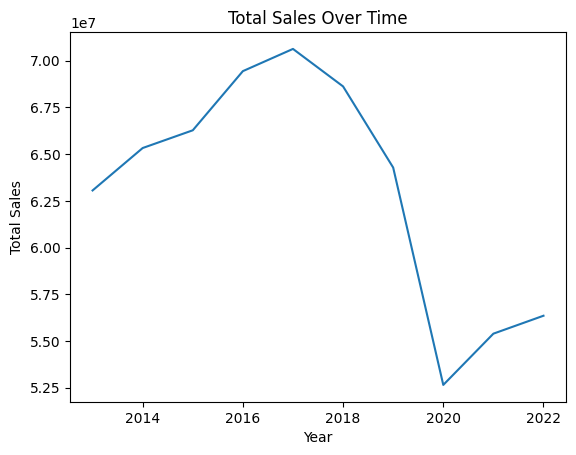

In [21]:
# @title Total Sales Over Time

import matplotlib.pyplot as plt

years = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
total_sales = [df_last_10y['2013_Sales'].sum(), df_last_10y['2014_Sales'].sum(), df_last_10y['2015_Sales'].sum(), df_last_10y['2016_Sales'].sum(),
              df_last_10y['2017_Sales'].sum(), df_last_10y['2018_Sales'].sum(), df_last_10y['2019_Sales'].sum(), df_last_10y['2020_Sales'].sum(),
              df_last_10y['2021_Sales'].sum(), df_last_10y['2022_Sales'].sum()]

plt.plot(years, total_sales)
plt.xlabel('Year')
plt.ylabel('Total Sales')
_ = plt.title('Total Sales Over Time')

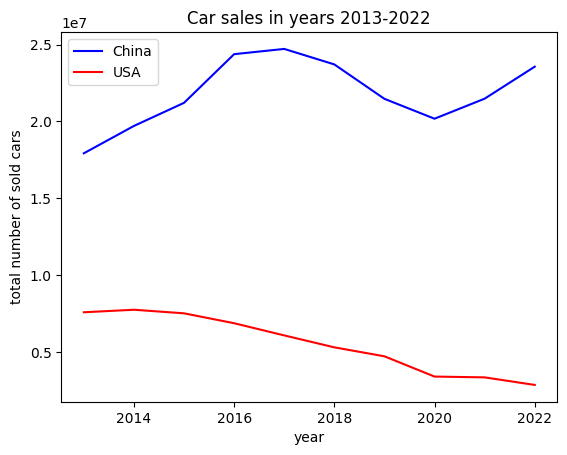

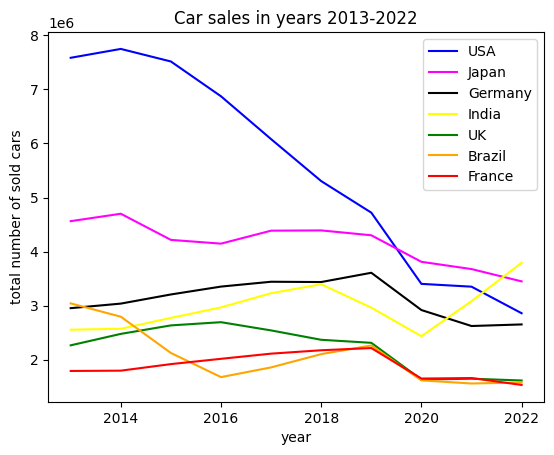

In [22]:
plt.figure(1)
plt.plot(range(2013, 2023), df_last_10y.iloc[0, 1:11], color='blue', linestyle='-', label=df_last_10y.iloc[0, 11])
plt.plot(range(2013, 2023), df_last_10y.iloc[1, 1:11], color='red', linestyle='-', label=df_last_10y.iloc[1, 11])
plt.ylabel("total number of sold cars")
plt.xlabel("year")
plt.title("Car sales in years 2013-2022")
plt.legend()

plt.figure(2)

plt.plot(range(2013, 2023), df_last_10y.iloc[1, 1:11], color='blue', linestyle='-', label=df_last_10y.iloc[1, 11])
plt.plot(range(2013, 2023), df_last_10y.iloc[2, 1:11], color='magenta', linestyle='-', label=df_last_10y.iloc[2, 11])
plt.plot(range(2013, 2023), df_last_10y.iloc[3, 1:11], color='black', linestyle='-', label=df_last_10y.iloc[3, 11])
plt.plot(range(2013, 2023), df_last_10y.iloc[4, 1:11], color='yellow', linestyle='-', label=df_last_10y.iloc[4, 11])
plt.plot(range(2013, 2023), df_last_10y.iloc[5, 1:11], color='green', linestyle='-', label=df_last_10y.iloc[5, 11])
plt.plot(range(2013, 2023), df_last_10y.iloc[6, 1:11], color='orange', linestyle='-', label=df_last_10y.iloc[6, 11])
plt.plot(range(2013, 2023), df_last_10y.iloc[7, 1:11], color='red', linestyle='-', label=df_last_10y.iloc[7, 11])
plt.ylabel("total number of sold cars")
plt.xlabel("year")
plt.title("Car sales in years 2013-2022")
plt.legend()
plt.show()

In [1]:
total_sales_2022 = df_last_10y["2022_Sales"].sum()
total_sales_2022_wo_top_5 = df_last_10y.loc[5:, "2022_Sales"].sum()

values = df_last_10y.loc[:4, "2022_Sales"].values
values = np.append(values, total_sales_2022_wo_top_5)
labels = df_last_10y.loc[:4, "Country"].values
labels = np.append(labels, "Rest of the world")

# Plotting the pie chart
plt.figure(figsize=(8, 8))  # Set the figure size
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)  # Create the pie chart
plt.title('Market share of car sales in 2022')  # Set the title
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Show the plot
plt.show()


NameError: name 'df_last_10y' is not defined

### Market share in 2022y

* every 4 out of 10 new car was sold in China!
* in five countries were solde nearly 2/3 of all new cars